In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rt-iot-resampled/resampled_dataset.csv
/kaggle/input/rt-iot2022/RT_IOT2022.csv


Epoch 10/40
Distillation loss: 0.7327
DQN loss: 0.0946
SSL loss: 0.1313
Total loss: 0.8924
---
Epoch 20/40
Distillation loss: 0.2456
DQN loss: 0.4199
SSL loss: 0.0715
Total loss: 0.4431
---
Epoch 30/40
Distillation loss: 0.2258
DQN loss: 0.6119
SSL loss: 0.0663
Total loss: 0.4757
---
Epoch 40/40
Distillation loss: 0.2193
DQN loss: 3.8379
SSL loss: 0.0601
Total loss: 1.4308
---
Accuracy: 0.9284, Precision: 0.9286, Recall: 0.9284, F1-score: 0.9266


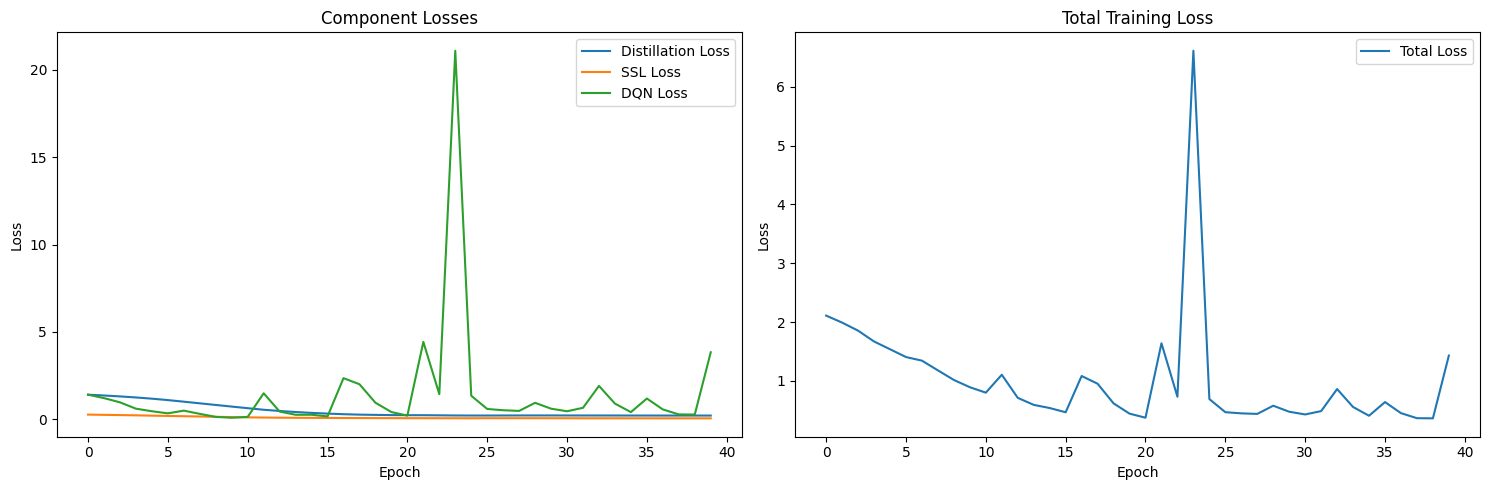

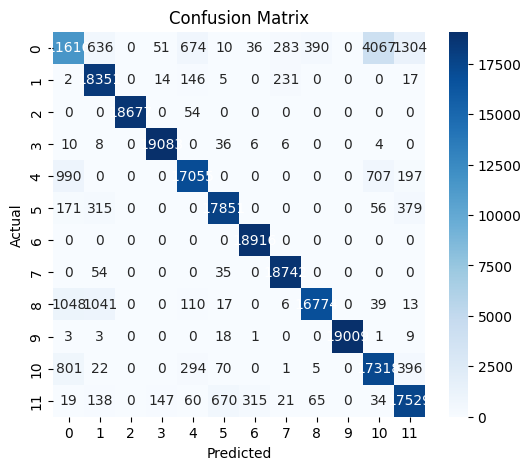

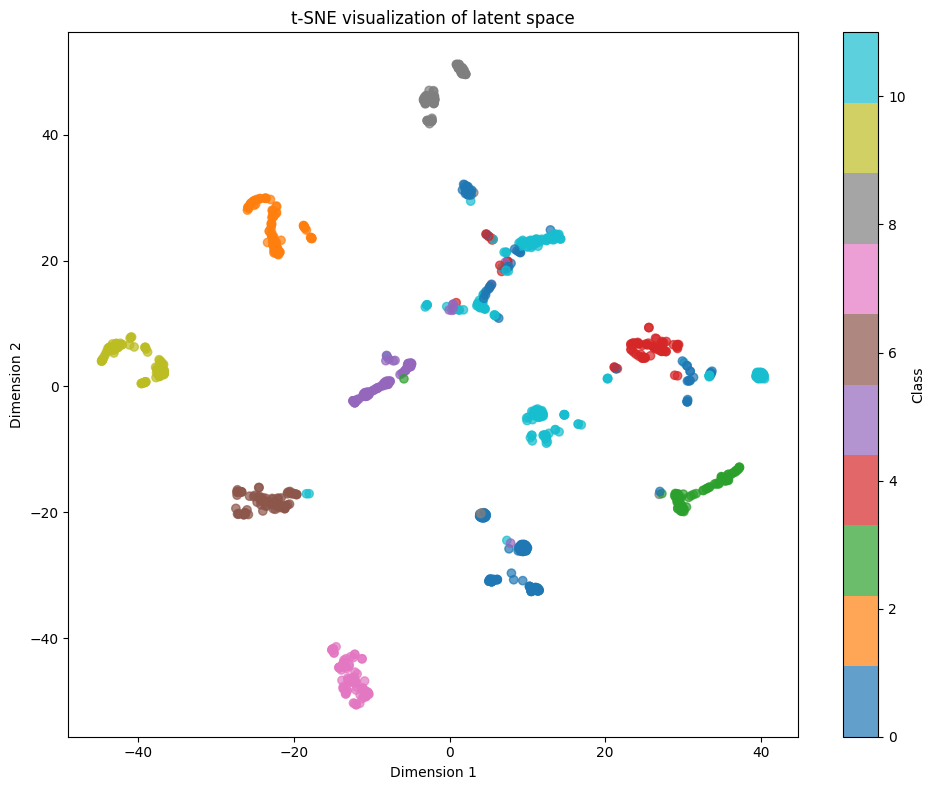

Enhanced model saved as enhanced_student_ssl_dqn_model.pkl
Average inference time per batch: 623.66 ms
Average inference time per sample: 0.00 ms


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
from collections import deque
import random

# Load dataset
data = pd.read_csv('/kaggle/input/rt-iot2022/RT_IOT2022.csv')

label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

X = data.drop(columns=['Attack_type'])
y = data['Attack_type']

# Encode categorical labels
y = LabelEncoder().fit_transform(y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define Teacher Model
class TeacherModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Define Enhanced Student Model with Self-Supervised Learning and DQN capabilities
class EnhancedStudentModel(nn.Module):
    def __init__(self, input_dim, num_classes, latent_dim=64):
        super(EnhancedStudentModel, self).__init__()
        # Encoder - shared across all tasks
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        
        # Classification head
        self.classifier = nn.Linear(latent_dim, num_classes)
        
        # Q-value head (for DQN functionality)
        self.q_values = nn.Linear(latent_dim, num_classes)
        
        # Self-supervised learning heads
        # 1. Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
        # 2. Feature prediction head (predicts masked features)
        self.feature_predictor = nn.Linear(latent_dim, input_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Get latent representation
        features = self.encoder(x)
        features_with_dropout = self.dropout(features)
        
        # Return outputs for all tasks
        return {
            'classification': self.classifier(features_with_dropout),
            'q_values': self.q_values(features_with_dropout),
            'reconstruction': self.decoder(features),
            'feature_prediction': self.feature_predictor(features)
        }
    
    def get_q_values(self, x):
        features = self.encoder(x)
        return self.q_values(features)
    
    def get_classification(self, x):
        features = self.encoder(x)
        return self.classifier(features)
    
    def get_latent_features(self, x):
        return self.encoder(x)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.stack(states), 
                torch.tensor(actions), 
                torch.tensor(rewards, dtype=torch.float32), 
                torch.stack(next_states), 
                torch.tensor(dones, dtype=torch.float32))
    
    def __len__(self):
        return len(self.buffer)

# Helper functions for self-supervised learning
def create_masked_inputs(x, mask_ratio=0.15):
    """Create masked versions of inputs for self-supervised learning"""
    batch_size, feat_dim = x.shape
    
    # Create a mask tensor (1 = keep, 0 = mask)
    mask = torch.ones_like(x)
    mask_indices = torch.bernoulli(torch.ones_like(x) * mask_ratio).bool()
    mask[mask_indices] = 0
    
    # Create masked input (replace masked values with zeros)
    masked_x = x * mask
    
    return masked_x, mask, x

# Training configurations
input_dim = X_train.shape[1]
num_classes = len(set(y))  # Dynamically determine number of classes
teacher = TeacherModel(input_dim, num_classes)
enhanced_student = EnhancedStudentModel(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()
distillation_criterion = nn.KLDivLoss(reduction='batchmean')
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.001)
optimizer_student = optim.Adam(enhanced_student.parameters(), lr=0.001)

def train_teacher(model, optimizer, criterion, X_train, y_train, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

train_teacher(teacher, optimizer_teacher, criterion, X_train_tensor, y_train_tensor)

# Modified Knowledge Distillation with DQN and Self-Supervised Learning integration
alpha = 0.5        # Weight for distillation loss
temperature = 3.0  # Temperature for distillation
beta = 0.3         # Weight for Q-learning loss
lambda_recon = 0.2 # Weight for reconstruction loss
lambda_feat = 0.2  # Weight for feature prediction loss

# Create a replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

# Function to create synthetic DQN training data from classification dataset
def generate_dqn_samples(X, y, num_samples=1000):
    buffer = ReplayBuffer()
    indices = np.random.choice(len(X), num_samples, replace=True)
    
    for i in indices:
        state = X[i]
        action = y[i]
        
        # Create a synthetic next state with small random perturbation
        next_state = state + torch.randn_like(state) * 0.01
        
        # Reward is 1 for correct action (this is simplified)
        reward = 1.0
        
        # Termination signal (simplified)
        done = 0.0
        
        buffer.add(state, action, reward, next_state, done)
    
    return buffer

# Pre-fill replay buffer with synthetic samples
replay_buffer = generate_dqn_samples(X_train_tensor, y_train_tensor)

def train_enhanced_student(teacher, student, optimizer, X_train, y_train, replay_buffer, 
                           epochs=40, gamma=0.99, batch_size=64, scheduler=None):
    teacher.eval()
    student.train()
    
    # Initialize target network (for stable DQN learning)
    target_network = EnhancedStudentModel(input_dim, num_classes)
    target_network.load_state_dict(student.state_dict())
    target_network.eval()
    
    history = {
        'distill_loss': [],
        'dqn_loss': [],
        'ssl_loss': [],
        'total_loss': []
    }
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Step 1: Create masked inputs for self-supervised learning
        masked_inputs, mask, original_inputs = create_masked_inputs(X_train_tensor)
        
        # Step 2: Forward pass with both original and masked inputs
        outputs = student(X_train_tensor)
        masked_outputs = student(masked_inputs)
        
        # Get teacher outputs for distillation
        teacher_outputs = teacher(X_train_tensor).detach()
        
        # Classification loss with distillation
        distill_loss = (alpha * distillation_criterion(
            F.log_softmax(outputs['classification']/temperature, dim=1), 
            F.softmax(teacher_outputs/temperature, dim=1)
        )) + ((1 - alpha) * criterion(outputs['classification'], y_train))
        
        # Self-supervised learning losses
        # 1. Reconstruction loss
        recon_loss = reconstruction_criterion(outputs['reconstruction'], X_train_tensor)
        
        # 2. Feature prediction loss (predict original features from masked input)
        feature_pred_loss = reconstruction_criterion(
            masked_outputs['feature_prediction'] * (1 - mask),  # Only compute loss on masked positions
            original_inputs * (1 - mask)
        )
        
        # Combined SSL loss
        ssl_loss = lambda_recon * recon_loss + lambda_feat * feature_pred_loss
        
        # DQN loss
        dqn_loss = torch.tensor(0.0)
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Current Q-values
            current_q = student.get_q_values(states)
            current_q_values = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)
            
            # Target Q-values
            with torch.no_grad():
                next_q = target_network.get_q_values(next_states)
                max_next_q = next_q.max(1)[0]
                target_q_values = rewards + gamma * max_next_q * (1 - dones)
            
            # Compute Q-learning loss
            dqn_loss = F.mse_loss(current_q_values, target_q_values)
        
        # Combined loss
        total_loss = distill_loss + beta * dqn_loss + ssl_loss
        total_loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        # Periodically update target network
        if epoch % 5 == 0:
            target_network.load_state_dict(student.state_dict())
            
        # Generate new synthetic DQN samples occasionally
        if epoch % 10 == 0:
            new_samples = generate_dqn_samples(X_train_tensor, y_train_tensor, num_samples=200)
            for s, a, r, ns, d in zip(*new_samples.sample(200)):
                replay_buffer.add(s, a, r, ns, d)
        
        # Record losses
        history['distill_loss'].append(distill_loss.item())
        history['dqn_loss'].append(dqn_loss.item() if isinstance(dqn_loss, torch.Tensor) else dqn_loss)
        history['ssl_loss'].append(ssl_loss.item())
        history['total_loss'].append(total_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Distillation loss: {distill_loss.item():.4f}")
            print(f"DQN loss: {dqn_loss.item() if isinstance(dqn_loss, torch.Tensor) else dqn_loss:.4f}")
            print(f"SSL loss: {ssl_loss.item():.4f}")
            print(f"Total loss: {total_loss.item():.4f}")
            print("---")
    
    return history

# Create learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer_student, 
    max_lr=0.01,
    steps_per_epoch=1, 
    epochs=40,
    pct_start=0.3,
    div_factor=10.0
)

# Train the enhanced student model
history = train_enhanced_student(
    teacher, 
    enhanced_student, 
    optimizer_student, 
    X_train_tensor, 
    y_train_tensor, 
    replay_buffer,
    epochs=40,
    scheduler=scheduler
)

# Evaluation function
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        class_outputs = outputs['classification'] if isinstance(outputs, dict) else outputs
        _, predictions = torch.max(class_outputs, 1)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    cm = confusion_matrix(y_test, predictions)
    return accuracy, precision, recall, f1, cm, predictions

# Evaluate the model
accuracy, precision, recall, f1, cm, predictions = evaluate(enhanced_student, X_test_tensor, y_test_tensor)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['distill_loss'], label='Distillation Loss')
plt.plot(history['ssl_loss'], label='SSL Loss')
plt.plot(history['dqn_loss'], label='DQN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Component Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature visualization using t-SNE (optional)
from sklearn.manifold import TSNE

def visualize_embeddings(model, X, y, n_samples=1000):
    """Visualize the learned embeddings using t-SNE"""
    if len(X) > n_samples:
        # Randomly sample data points
        indices = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[indices]
        y_sample = y[indices]
    else:
        X_sample = X
        y_sample = y
    
    # Extract latent features
    model.eval()
    with torch.no_grad():
        latent_features = model.get_latent_features(X_sample).cpu().numpy()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(latent_features)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_sample.cpu().numpy(), 
                          cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class')
    plt.title('t-SNE visualization of latent space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

# Visualize embeddings (choose a subset of test data)
visualize_embeddings(enhanced_student, X_test_tensor, y_test_tensor)

# Save the trained enhanced student model
model_filename = "enhanced_student_ssl_dqn_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(enhanced_student, file)

print(f"Enhanced model saved as {model_filename}")

# Benchmark model inference speed
def benchmark_inference_speed(model, X_test, num_runs=100):
    """Benchmark the model's inference speed"""
    model.eval()
    
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(X_test)
    end_time = time.time()
    
    avg_time_per_batch = (end_time - start_time) / num_runs
    avg_time_per_sample = avg_time_per_batch / len(X_test)
    
    return avg_time_per_batch, avg_time_per_sample

import time

# Benchmark the enhanced model
batch_time, sample_time = benchmark_inference_speed(enhanced_student, X_test_tensor)
print(f"Average inference time per batch: {batch_time*1000:.2f} ms")
print(f"Average inference time per sample: {sample_time*1000:.2f} ms")

Trial 10 Complete [00h 02m 40s]
val_prc: 0.9999991655349731

Best val_prc So Far: 0.9999991655349731
Total elapsed time: 00h 32m 27s
Best hyperparameters: {'neurons1': 192, 'dropout_rate1': 0.4, 'neurons2': 96, 'dropout_rate2': 0.4}
Epoch 1/100
1539/1539 - 10s - 6ms/step - accuracy: 0.9654 - auc: 0.9886 - loss: 1.4567 - prc: 0.9927 - precision: 0.9988 - recall: 0.9318 - val_accuracy: 0.9670 - val_auc: 0.9997 - val_loss: 0.4538 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9667 - learning_rate: 0.0010
Epoch 2/100
1539/1539 - 7s - 5ms/step - accuracy: 0.9785 - auc: 0.9928 - loss: 0.2935 - prc: 0.9956 - precision: 0.9999 - recall: 0.9572 - val_accuracy: 0.9642 - val_auc: 0.9980 - val_loss: 0.2654 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9639 - learning_rate: 0.0010
Epoch 3/100
1539/1539 - 7s - 5ms/step - accuracy: 0.9759 - auc: 0.9938 - loss: 0.2061 - prc: 0.9961 - precision: 0.9999 - recall: 0.9518 - val_accuracy: 0.9578 - val_auc: 0.9971 - val_loss: 0.2941 -

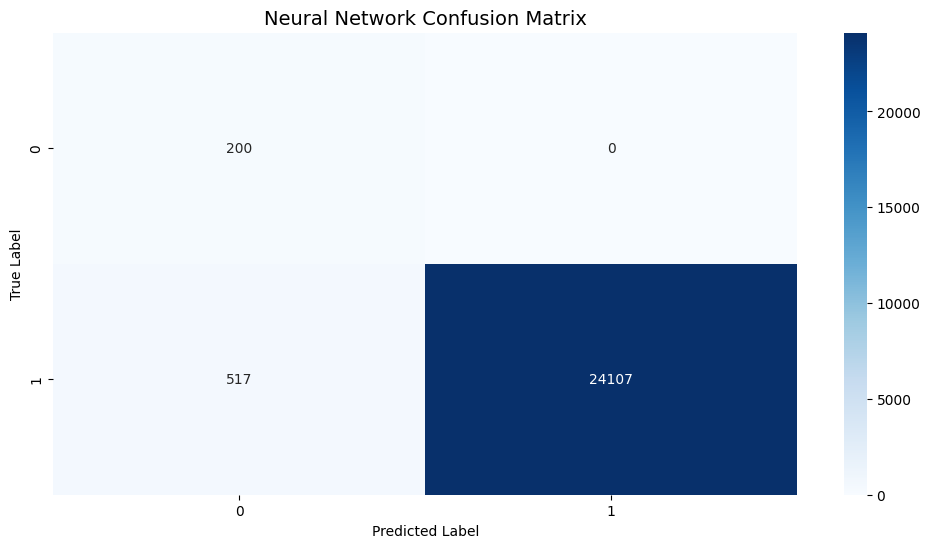

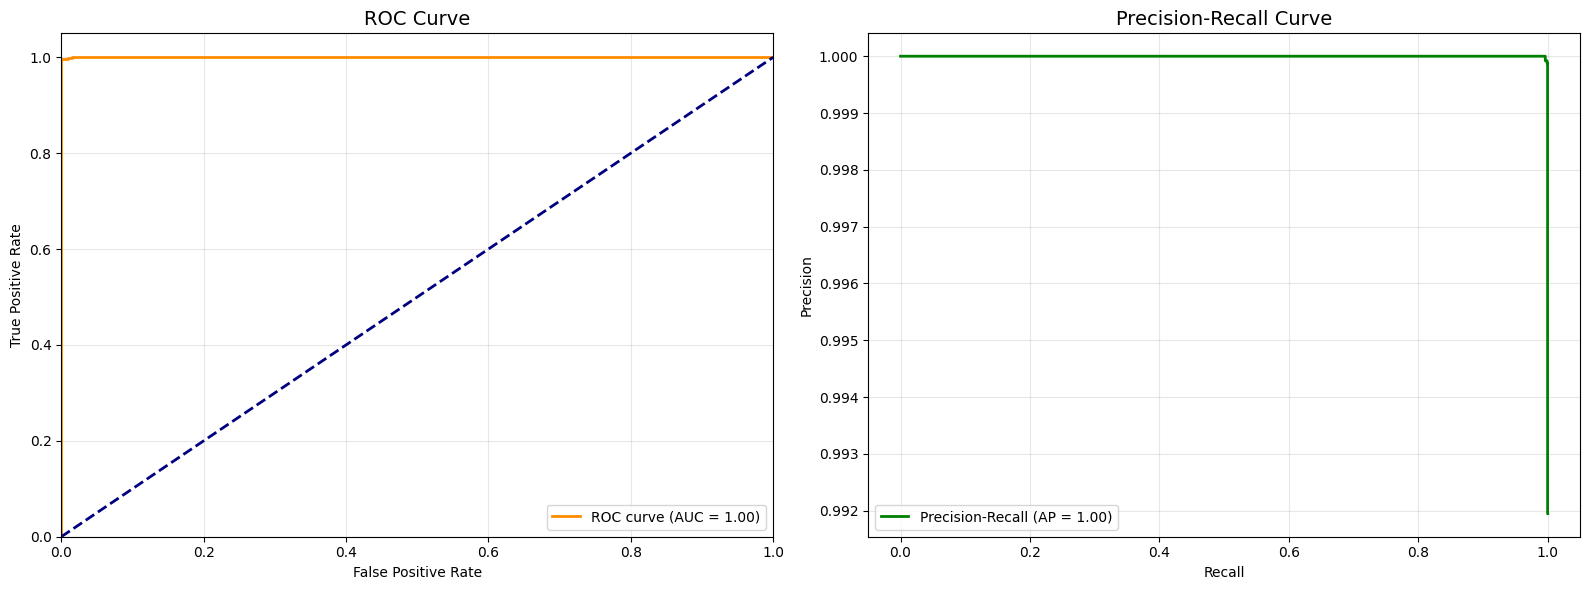

Optimal threshold based on F1-score: 0.10

=== FINAL MODEL PERFORMANCE WITH OPTIMAL THRESHOLD ===
Test accuracy: 0.9960

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       200
           1       1.00      1.00      1.00     24624

    accuracy                           1.00     24824
   macro avg       0.83      1.00      0.90     24824
weighted avg       1.00      1.00      1.00     24824



In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (precision_recall_fscore_support, confusion_matrix,
                             accuracy_score, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import mutual_info_classif
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import keras_tuner as kt

# === DATA LOADING AND PREPROCESSING ===
# Load dataset
df = pd.read_csv("/kaggle/input/rt-iot2022/RT_IOT2022.csv")

# Initial data inspection
print("Dataset shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

# Check for infinite values and replace with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Fill missing values with the median, but only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle missing values in non-numeric columns (optional)
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna('unknown')  # or any other placeholder

# Convert Attack_type to binary labels (0 = Normal, 1 = Attack)
if 'Attack_type' in df.columns:
    df['Attack_label'] = (df['Attack_type'] != 'Normal').astype(int)
    print(f"Attack distribution: {df['Attack_label'].value_counts()}")
    print(f"Attack percentage: {df['Attack_label'].mean()*100:.2f}%")
else:
    raise ValueError("Attack_type column missing from dataset")

# Synthetic sample creation if only one class is detected
if df['Attack_label'].nunique() < 2:
    print("WARNING: Only one class detected. Creating synthetic samples for the other class...")
    majority_class = df['Attack_label'].iloc[0]
    majority_samples = df.sample(min(1000, len(df)), random_state=42)
    minority_samples = majority_samples.copy()
    
    numeric_cols = minority_samples.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col != 'Attack_label':
            if majority_class == 1:  # All attacks, create normal
                minority_samples[col] = minority_samples[col] * np.random.uniform(0.3, 0.7, len(minority_samples))
            else:  # All normal, create attacks
                minority_samples[col] = minority_samples[col] * np.random.uniform(1.5, 3, len(minority_samples))
    
    minority_samples['Attack_label'] = 1 - majority_class
    if 'Attack_type' in minority_samples.columns:
        minority_samples['Attack_type'] = 'Normal' if majority_class == 1 else 'Synthetic_Attack'
    
    df = pd.concat([df, minority_samples]).reset_index(drop=True)
    print(f"New dataset shape: {df.shape}")
    print(f"New class distribution: {df['Attack_label'].value_counts()}")

# Separate labels before further preprocessing
labels = df['Attack_label']
# Keep proto, service, Attack_type only if needed for analysis then drop them for modeling
df = df.drop(columns=['proto', 'service', 'Attack_type', 'Attack_label'], errors='ignore')

# === FEATURE SELECTION USING MUTUAL INFORMATION ===
mi_scores = mutual_info_classif(df, labels)
mi_threshold = 0.01  # Adjust threshold as needed
selected_features = df.columns[mi_scores > mi_threshold]
df = df[selected_features]
print(f"Selected {len(selected_features)} features based on mutual information (threshold={mi_threshold})")

# Remove highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(columns=high_corr_features)
print(f"Removed {len(high_corr_features)} highly correlated features")

# === FEATURE SCALING ===
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# === MODEL CREATION WITH HYPERPARAMETER TUNING ===
# === MODEL CREATION WITH HYPERPARAMETER TUNING ===
def build_model(hp):
    input_dim = df_scaled.shape[1]
    inputs = keras.Input(shape=(input_dim,))
    
    # Tune number of neurons for first hidden layer
    neurons1 = hp.Int('neurons1', min_value=128, max_value=512, step=64)
    dropout_rate1 = hp.Float('dropout_rate1', min_value=0.3, max_value=0.7, step=0.1)
    x = layers.Dense(neurons1, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate1)(x)
    
    # Tune second hidden layer parameters
    neurons2 = hp.Int('neurons2', min_value=64, max_value=256, step=32)
    dropout_rate2 = hp.Float('dropout_rate2', min_value=0.3, max_value=0.7, step=0.1)
    x = layers.Dense(neurons2, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate2)(x)
    
    # Third hidden layer (fixed configuration)
    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc'),
                 keras.metrics.AUC(name='prc', curve='PR')]
    )
    return model

# Define the objective for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_prc", direction="max"),  # Maximize the PRC
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='iot_attack_detection'
)
   

# === STRATIFIED K-FOLD CROSS-VALIDATION ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
val_scores = []

for train_index, val_index in skf.split(df_scaled, labels):
    print(f"\nTraining fold {fold_no}...")
    X_train, X_val = df_scaled[train_index], df_scaled[val_index]
    y_train, y_val = labels.iloc[train_index], labels.iloc[val_index]
    
    # Resample training data with SMOTE-Tomek
    smote_tomek = SMOTETomek(random_state=42)
    X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)
    print("Class distribution after SMOTE-Tomek:", pd.Series(y_train_bal).value_counts())
    
    # Calculate class weights based on original training split
    class_weight = {
        0: len(y_train) / (2 * np.sum(y_train == 0)),
        1: len(y_train) / (2 * np.sum(y_train == 1))
    }
    print(f"Fold {fold_no} class weights: {class_weight}")
    
    # Set callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(
        monitor='val_prc', 
        patience=15,
        restore_best_weights=True,
        mode='max'
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-5,
        verbose=1
    )
    
    # Run hyperparameter tuning on the first fold only (for demonstration)
    if fold_no == 1:
        tuner.search(X_train_bal, y_train_bal, epochs=20, validation_data=(X_val, y_val),
                     callbacks=[early_stopping, reduce_lr],
                     class_weight=class_weight,
                     batch_size=128)
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print("Best hyperparameters:", best_hps.values)
    
    # Build model with best hyperparameters if available, else default from tuner search
    model = build_model(best_hps) if fold_no == 1 else build_model(kt.HyperParameters())
    
    history = model.fit(
        X_train_bal, y_train_bal,
        epochs=100,
        batch_size=128,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight,
        verbose=2
    )
    
    # Evaluate on validation fold
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} validation scores: {model.metrics_names} -> {scores}")
    val_scores.append(scores)
    fold_no += 1

# === FINAL EVALUATION ON A HELD-OUT TEST SET ===
# Split the data into train and test sets (80/20 stratified split)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Resample training data with SMOTE-Tomek on the full training set
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_full, y_train_full)
print("\nFinal training class distribution after SMOTE-Tomek:")
print(pd.Series(y_train_balanced).value_counts())

# Calculate class weights for the full training set
class_weight_full = {
    0: len(y_train_full) / (2 * np.sum(y_train_full == 0)),
    1: len(y_train_full) / (2 * np.sum(y_train_full == 1))
}
print(f"Final class weights: {class_weight_full}")

# Build final model using best hyperparameters from tuning
final_model = build_model(best_hps)

# Set final callbacks
final_early_stopping = EarlyStopping(
    monitor='val_prc',
    patience=15,
    restore_best_weights=True,
    mode='max'
)
final_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

# Train final model
final_history = final_model.fit(
    X_train_balanced, y_train_balanced,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[final_early_stopping, final_reduce_lr],
    class_weight=class_weight_full,
    verbose=2
)

# === PERFORMANCE VISUALIZATION ===
# Predict probabilities and apply threshold adjustment on test set
nn_raw_predictions = final_model.predict(X_test).flatten()

# Plot Confusion Matrix
nn_predictions = (nn_raw_predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, nn_predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title('Neural Network Confusion Matrix', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC and Precision-Recall Curves
plt.figure(figsize=(16, 6))
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, nn_raw_predictions)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, nn_raw_predictions)
average_precision = average_precision_score(y_test, nn_raw_predictions)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === THRESHOLD ADJUSTMENT ===
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []

for threshold in thresholds:
    nn_thresh_predictions = (nn_raw_predictions > threshold).astype(int)
    precision_val, recall_val, f1, _ = precision_recall_fscore_support(y_test, nn_thresh_predictions, average='binary')
    accuracy_val = accuracy_score(y_test, nn_thresh_predictions)
    threshold_metrics.append([threshold, accuracy_val, precision_val, recall_val, f1])

threshold_df = pd.DataFrame(threshold_metrics, 
                           columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
optimal_threshold = threshold_df.loc[threshold_df['F1-Score'].idxmax(), 'Threshold']
print(f"Optimal threshold based on F1-score: {optimal_threshold:.2f}")

# Evaluate with the optimal threshold
optimal_predictions = (nn_raw_predictions > optimal_threshold).astype(int)
print("\n=== FINAL MODEL PERFORMANCE WITH OPTIMAL THRESHOLD ===")
print(f"Test accuracy: {accuracy_score(y_test, optimal_predictions):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, optimal_predictions))
